In [1]:
import pickle
import numpy as np
from fourier import rangeFFT, angleFFT, dopplerFFT
from raw_signal import RadarData
from params import PARAMS
import PyQt6
import datetime
import matplotlib.pyplot as plt
# %matplotlib widget
# %matplotlib inline

In [2]:
## Load files and get FRAMES
# Load data from file

data = pickle.load(open('data/openradar_23-03-23_UDE-IHRABST4PA.dat', 'rb'))
# Load config parameters
config = data['config']
PARAMS.set_playback_mode(config)
# Read main parameters
rdata = RadarData(device='IWR1843',
                  tx=PARAMS.TX_ANTENNAS,
                  rx=PARAMS.RX_ANTENNAS,
                  loops=PARAMS.CHIRP_LOOPS,
                  samples=PARAMS.ADC_SAMPLES)

# Get data frame
frames = data['data']

In [ ]:
## 1D-FFT example
from scipy.interpolate import CubicSpline
# Choose frame
adc_data = frames[2]
# Set RadarData raw_data
rdata.raw_data = adc_data
# Access data separated by Rx and Tx antennas
v_array = rdata.separated_vx_data
# 1D RANGE FFT and radar cube
[RC, rFFT, rBins] = rangeFFT(v_array[100,:,:],rdata.device)
# The range profile can be extracted from this as
rProf = np.mean(abs(rFFT[:,0:128]),axis=0)[8:]
# Cubic Spline
f = CubicSpline(rBins[8:128],rProf, bc_type='natural')
xnew= np.linspace(rBins[8],rBins[128],num=1000)
ynew = f(xnew)
# yinterp = np.interp(xvals, rBins[8:128], np.mean(abs(rFFT[:,0:128]),axis=0)[8:])
plt.plot(xnew,ynew)
plt.xlabel('Range (m)')
plt.grid(visible=True)
# plt.show()
# plt.savefig('images/rProfile.png',dpi=600)

In [ ]:
## Animation range profile
from IPython.display import display, clear_output

fig, ax = plt.subplots()
line1 = ax.plot(0, 0)


ax.set_title('Range Profile')
ax.set_xlabel('Range (m)')
ax.grid(visible=True)


for n in range(np.size(frames,0)):
    # Choose frame
    adc_data = frames[n]
    # Set RadarData raw_data
    rdata.raw_data = adc_data
    # Access data separated by Rx and Tx antennas
    v_array = rdata.separated_vx_data
    ## 1D RANGE FFT and radar cube
    [RC, rFFT, rBins] = rangeFFT(v_array[100,:,:],rdata.device)
    # The range profile can be extracted from this as
    rProf = np.mean(abs(rFFT[:,0:128]),axis=0)[8:]
    # Cubic Spline
    f = CubicSpline(rBins[8:128],rProf, bc_type='natural')
    xnew= np.linspace(rBins[8],rBins[128],num=1000)
    ynew = f(xnew)

    ax.cla()
    ax.set_title('Range Profile')
    ax.set_xlabel('Range (m)')
    ax.grid(visible=True)
    ax.set_ylim(0,130000)
    ax.plot(xnew,ynew)
    ax.legend(['Frame #' + str(n+1)])
    display(fig)
    clear_output(wait = True)
    # fig.savefig('images/rProf'+str(n+1),dpi=600)
    plt.pause(0.1)

In [ ]:
## Phase evolution (1-frame)

fig, ax1 = plt.subplots()

ax1.set_title('Phase evolution in one frame')
ax1.set_xlabel('Chirp number')
ax1.set_ylabel('Phase (deg)')
ax1.grid(visible=True)
ax1.tick_params(axis='y',labelcolor='red')

ax2 = ax1.twinx()
ax2.set_ylabel('Target bin')
ax2.tick_params(axis ='y', labelcolor = 'blue') 

adc_data = frames[10]
# Set RadarData raw_data
rdata.raw_data = adc_data
# Access data separated by Rx and Tx antennas
v_array = rdata.separated_vx_data
## 1D RANGE FFT and radar cube
[RC, rFFT, rBins] = rangeFFT(v_array[0,:,:64],rdata.device)
rMaxLoc = np.argmax(abs(rFFT))
# plt.plot(abs(rFFT[0,:128]))
# plt.show()
rPhase = np.zeros((1,np.size(v_array,0)))
rm = np.zeros((1,np.size(v_array,0)))

for n in range(np.size(v_array,0)):
    ## 1D RANGE FFT and radar cube
    [RC, rFFT, rBins] = rangeFFT(v_array[n,:,:64],rdata.device)
    # The range profile can be extracted from this as
    rPhase[0,n] = np.angle(rFFT[0,rMaxLoc],deg=True)
    rm[0,n] = np.argmax(abs(rFFT))

    
ax2.plot(rm.T,color='blue')
ax1.plot(rPhase.T,color='red')
plt.show()
# fig.savefig('images/phaseEvolution',dpi=600)


In [3]:
from scipy import stats as st
[RC, rFFT, rBins] = rangeFFT(v_array[0,:,:],rdata.device)
# plt.plot(abs(rFFT[4,:64]).T)
# plt.show()
rMaxLoc =  np.argmax(abs(rFFT[:,:64]),axis=1)[0]
print(rMaxLoc)


NameError: name 'v_array' is not defined

In [3]:
## Phase evolution

fini = 1
ffin = 51

# rPhase = np.zeros((ffin-fini+1,255))
# rm = np.zeros((ffin-fini+1,255))
Pmean = np.zeros(((ffin-fini),12))
P = np.zeros(((ffin-fini)*255,12))
# P = []

for fr in range(fini,ffin):
# for n in range(0):
    adc_data = frames[fr]
    # Set RadarData raw_data
    rdata.raw_data = adc_data
    # Access data separated by Rx and Tx antennas
    v_array = rdata.separated_vx_data
    
    
    for chirp in range(np.size(v_array,0)):
        ## 1D RANGE FFT and radar cube
        [_, rFFT, _] = rangeFFT(v_array[chirp,:,:],rdata.device)

        binMax = np.argmax(abs(rFFT[:,:40]),axis=1)[2]  # One of the antennas must be taken (arbitrarily 2 for now)
        P[255*(fr-fini)+chirp,:] = np.unwrap(np.angle(rFFT[:,int(binMax)],deg=True),period=360)
    
    Pmean[fr-fini,:] = np.median(P[255*(fr-fini):255*(fr-fini+1)-1,:],axis=0)
    # for ant in range(np.size(v_array,1)):
    #     Pmean[ant,]
        


In [6]:
# Time Calculation
t1 = [datetime.timedelta(0)]
for n in range(fini,ffin-1):
    t1.append(t1[n-fini] + data["timestamps"][n]-data["timestamps"][n-1])
# del t1[0]
t=[]
for n in range(len(t1)):
    t.append(t1[n].total_seconds())
tfinal = []
for n in range(np.size(t)):
    tfinal.append(np.linspace(t[n],t[n]+40e-3,255))
tfinal = np.concatenate(tfinal)

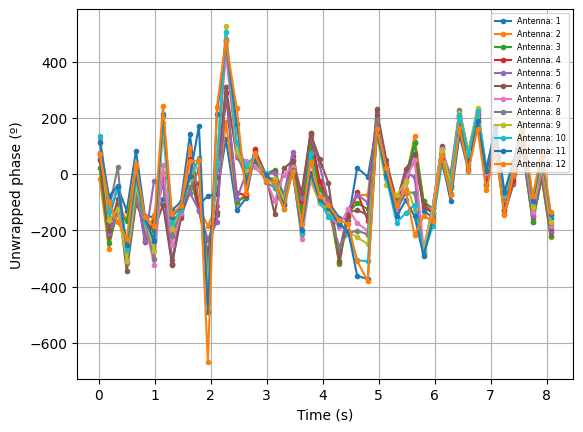

In [7]:
# Median phase for different antennas

for ant in range(12):
    # plt.plot(tfinal,P[:,ant],'.-')
    plt.plot(np.array(t) + 0.02,Pmean[:,ant].T,'.-',label='Antenna: '+ str(ant+1))
# plt.plot(np.median(P,axis=0),c="C1")
plt.xlabel('Time (s)')
plt.ylabel('Unwrapped phase (º)')
plt.grid()
plt.legend(loc='upper right',fontsize='xx-small')
plt.show()

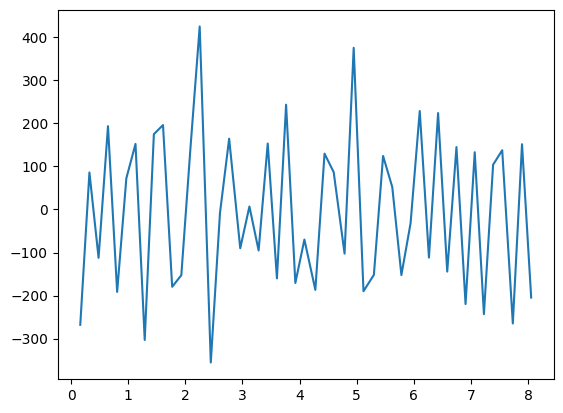

In [127]:
# Phase differences
PD = np.zeros((np.size(Pmean,0)-1,12))
for ant in range(12):
    for n in range(np.size(Pmean[:,ant])-1):
        PD[n,ant] = (Pmean[n+1,ant] - Pmean[n,ant])
plt.plot(t[1:],PD[:,3])
plt.show()

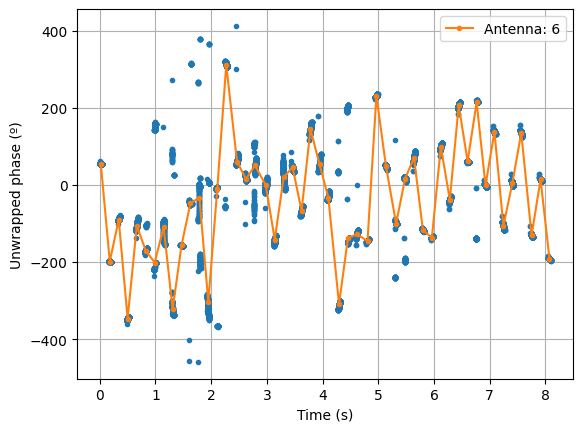

In [14]:
# Median phase for different antennas
ant = 5

plt.plot(tfinal,P[:,ant],'.')
plt.plot(np.array(t) + 0.02,Pmean[:,ant].T,'.-',label='Antenna: '+ str(ant+1))
# plt.plot(np.median(P,axis=0),c="C1")
plt.xlabel('Time (s)')
plt.ylabel('Unwrapped phase (º)')
plt.grid()
plt.legend(loc='upper right')
plt.show()

In [52]:
len(t[:-1])

49

(-500.0, 500.0)

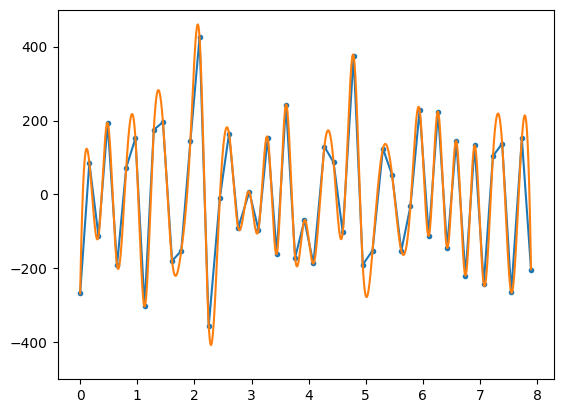

In [60]:
from scipy.interpolate import CubicSpline
from scipy.signal import savgol_filter
plt.plot(t[:-1],PD,c="C0",marker='.')
# Savitzky-Golay filter to smooth the curve
# plt.plot(t[1:],savgol_filter(PD,6,5),c="C1",label="S-G Filtered Velocity")
cs = CubicSpline(t[:-1],PD)
ts = np.arange(t[0], t[-2], 0.001)
plt.plot(ts,cs(ts),c="C1")
plt.ylim((-500,500))

In [132]:
# Period calculation
T = []
for pp in range(len(t)-1):
    T.append(t[pp+1]-t[pp])
T = np.mean(T)

In [134]:
print(np.mean(T))

0.1643617755102041


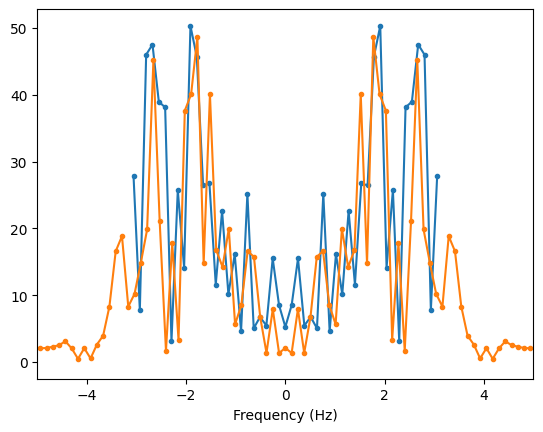

In [66]:
# Fourier Analysis
T = 0.16 
Fs = 1/T                                
L = len(PD)            
freq = np.fft.fftshift(np.fft.fftfreq(L,T))
FT = np.fft.fftshift(abs(np.fft.fft(PD,axis=0))/L)
# freq = np.fft.fftfreq(len(FT),0.16)
plt.plot(freq,abs(FT),'.-')
plt.xlabel('Frequency (Hz)')


# PDinterp = cs(ts)
# T1 = 1e-3
# Fs1 = 1/T                                
# L1 = len(PDinterp)            
# freq1 = np.fft.fftshift(np.fft.fftfreq(L1,T1))
# FT1 = np.fft.fftshift(abs(np.fft.fft(PDinterp,axis=0))/L1)
# plt.plot(freq1,abs(FT1),'.-')
# plt.xlabel('Frequency (Hz)')
# plt.xlim((-5,5))

plt.show()

Text(0.5, 0, 'Frequency (Hz)')

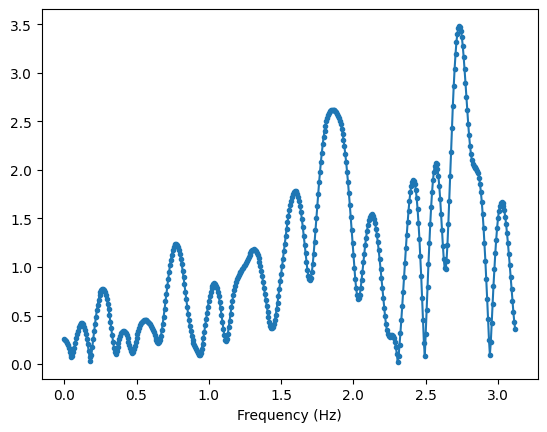

In [121]:
# Fourier Analysis -- zero padding 
T = 0.16 
Fs = 1/T                                
L = 1000            
freq = np.fft.fftshift(np.fft.fftfreq(L,T))
FT = np.fft.fftshift(abs(np.fft.fft(PD,L,axis=0))/L)
# freq = np.fft.fftfreq(len(FT),0.16)
plt.plot(freq[500:],abs(FT[500:]),'.-')
plt.xlabel('Frequency (Hz)')

In [135]:
range(50,451)

range(50, 450)

In [82]:
# Butterworth filter definition

from scipy.signal import butter, lfilter
from scipy.signal import freqz

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

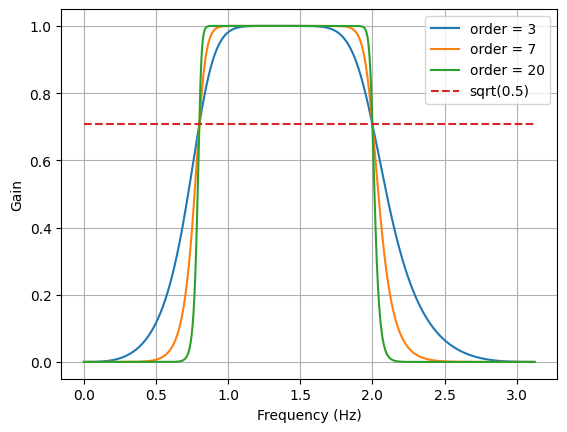

In [96]:
# Filter design
## Breathing 0.1-0.6 Hz
# lowcut = 0.1
# highcut = 0.4

# for order in [3, 7, 9]:
#         b, a = butter_bandpass(lowcut, highcut, Fs, order=order)
#         w, h = freqz(b, a, worN=2000)
#         plt.plot((Fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

# plt.plot([0, 0.5 * Fs], [np.sqrt(0.5), np.sqrt(0.5)],
#             '--', label='sqrt(0.5)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Gain')
# plt.grid(True)
# plt.legend(loc='best')

## Heart rate 0.8-2.0 Hz
lowcut = 0.8
highcut = 2.0

for order in [3, 7, 20]:
        b, a = butter_bandpass(lowcut, highcut, Fs, order=order)
        w, h = freqz(b, a, worN=2000)
        plt.plot((Fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * Fs], [np.sqrt(0.5), np.sqrt(0.5)],
            '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')


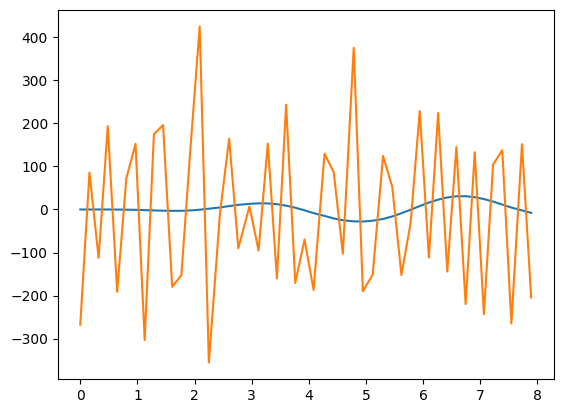

In [106]:
y1 = butter_bandpass_filter(PD, 0.1, 0.4, Fs, order=7)
plt.plot(t[:-1], y1)
plt.plot(t[:-1],PD)

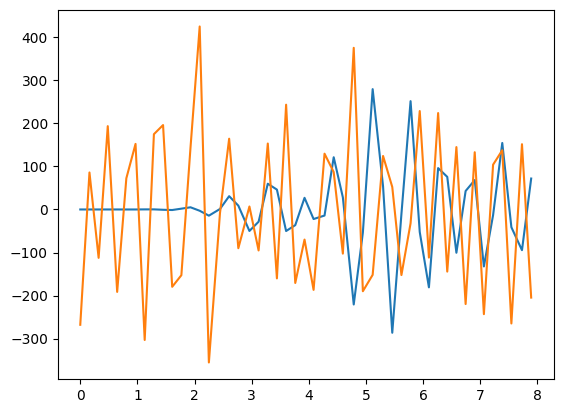

In [104]:
y2 = butter_bandpass_filter(PD, 0.8, 2.0, Fs, order=20)
plt.plot(t[:-1], y2)
plt.plot(t[:-1],PD)

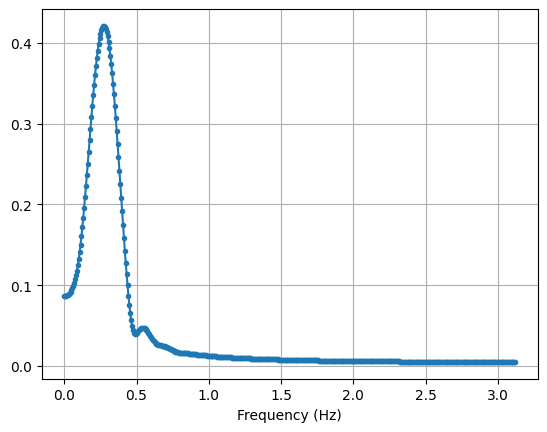

In [119]:
# Fourier Analysis -- zero padding 
T = 0.16 
Fs = 1/T                                
L = 1000            
freq = np.fft.fftshift(np.fft.fftfreq(L,T))
FT = np.fft.fftshift(abs(np.fft.fft(y1,L,axis=0))/L)
# freq = np.fft.fftfreq(len(FT),0.16)
plt.plot(freq[int(L/2):],abs(FT[int(L/2):]),'.-')
plt.xlabel('Frequency (Hz)')
plt.grid()

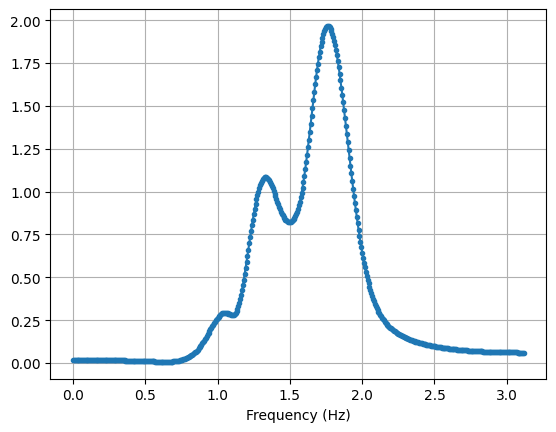

In [120]:
# Fourier Analysis -- zero padding 
T = 0.16 
Fs = 1/T                                
L = 1000            
freq = np.fft.fftshift(np.fft.fftfreq(L,T))
FT = np.fft.fftshift(abs(np.fft.fft(y2,L,axis=0))/L)
# freq = np.fft.fftfreq(len(FT),0.16)
plt.plot(freq[int(L/2):],abs(FT[int(L/2):]),'.-')
plt.xlabel('Frequency (Hz)')
plt.grid()

In [ ]:
data.keys()